# Causal Uplift & Revenue Optimization for VOD

This notebook demonstrates the complete workflow for building a causal uplift model
to optimize promotional campaigns for a Video-on-Demand platform.

## Contents

1. **Data Generation** - Create synthetic VOD dataset with hidden causal effects
2. **Feature Engineering** - Transform raw logs into model features
3. **X-Learner Training** - Train causal model with XGBoost base learners
4. **Model Evaluation** - Qini curves, AUUC, and oracle validation
5. **Policy Simulation** - Generate recommendations and simulate ROI

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Setup complete!")

Setup complete!


In [2]:
# Import our modules
import sys
sys.path.insert(0, '..\src')

from vod_causal.data import VODSyntheticData, CausalOracle
from vod_causal.preprocessing import FeatureTransformer, PropensityModel
from vod_causal.models import BaseLearners, XLearner, DoubleMachineLearning
from vod_causal.evaluation import (
    UpliftMetrics, PolicyRanker,
    plot_qini_curve, plot_cate_distribution, plot_cate_calibration,
    plot_propensity_distribution, create_evaluation_dashboard
)

print("Modules imported successfully!")

Modules imported successfully!


---

## 1. Data Generation

Generate synthetic VOD data with 10,000 users and 500 titles. The dataset includes
a hidden causal structure (via `CausalOracle`) that represents the true treatment effects.

In [3]:
# Initialize generator
generator = VODSyntheticData(
    n_users=10_000,
    n_titles=500,
    n_interactions=100_000,
    treatment_probability=0.15,  # ~15% of interactions are treated
    seed=42
)

# Generate all data
data = generator.generate_all()

print("Generated datasets:")
for name, df in data.items():
    if isinstance(df, pd.DataFrame):
        print(f"  {name}: {df.shape}")
    else:
        print(f"  {name}: {df}")

Generated datasets:
  titles_metadata: (500, 7)
  users_metadata: (10000, 6)
  treatment_log: (100000, 6)
  interaction_outcomes: (100000, 9)
  summary: {'n_users': 10000, 'n_titles': 500, 'n_interactions': 100000, 'treatment_rate': np.float64(0.17109), 'conversion_rate': np.float64(0.4639), 'avg_revenue': np.float64(2.19886346), 'avg_true_cate': np.float64(0.3471691130050551), 'cold_start_titles': np.int64(50)}


In [4]:
# Examine the summary statistics
print("\nDataset Summary:")
print("="*50)
for key, value in data['summary'].items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")


Dataset Summary:
n_users                       : 10000
n_titles                      : 500
n_interactions                : 100000
treatment_rate                : 0.1711
conversion_rate               : 0.4639
avg_revenue                   : 2.1989
avg_true_cate                 : 0.3472
cold_start_titles             : 50


In [5]:
# Explore the data
print("\n=== Users Metadata ===")
display(data['users_metadata'].head())

print("\n=== Titles Metadata ===")
display(data['titles_metadata'].head())

print("\n=== Treatment Log ===")
display(data['treatment_log'].head())

print("\n=== Interaction Outcomes ===")
display(data['interaction_outcomes'].head())


=== Users Metadata ===


,user_id,subscription_tenure_months,geo_region,device_type,avg_daily_watch_time,price_sensitivity
0,USER_000000,1,APAC,Mobile,64.6713,0.6893
1,USER_000001,7,US,Mobile,22.9799,0.1905
2,USER_000002,19,US,Mobile,37.1697,0.2765
3,USER_000003,2,US,SmartTV,100.4491,0.3947
4,USER_000004,13,EU,SmartTV,92.6604,0.4632



=== Titles Metadata ===


,title_id,genre,director,release_year,warm_embedding,is_cold_start,base_popularity
0,TITLE_00000,Documentary,Director_J,2012,"[0.1970228410695499, -0.4086890452047951, -0.2...",False,0.9500
1,TITLE_00001,Action,Director_G,2022,"[0.043842548980431925, 0.1625105043819321, 0.1...",False,0.8322
2,TITLE_00002,Comedy,Director_M,2019,"[0.03222506621799034, 0.38248706995192483, -0....",False,0.8481
3,TITLE_00003,Thriller,Director_A,2023,"[-0.2806938154972635, 0.07059491013470812, 0.0...",False,0.8313
4,TITLE_00004,Drama,Director_M,2020,"[-0.07840263660848153, -0.11553909731863164, 0...",False,0.9355



=== Treatment Log ===


,user_id,title_id,discount_level,campaign_id,timestamp,is_treated
0,USER_004543,TITLE_00076,0.0000,NO_TREATMENT,2024-02-29 08:08:55.639001,False
1,USER_004819,TITLE_00380,0.0000,NO_TREATMENT,2024-02-15 22:54:02.568372,False
2,USER_006415,TITLE_00186,0.0000,NO_TREATMENT,2024-01-08 18:02:17.541445,False
3,USER_007612,TITLE_00046,0.2000,CAMP_002,2024-01-27 22:48:45.199324,True
4,USER_005058,TITLE_00431,0.0000,NO_TREATMENT,2024-03-30 02:01:36.510526,False



=== Interaction Outcomes ===


,user_id,title_id,did_rent,revenue_generated,watch_duration_minutes,base_price,true_cate,y0,y1
0,USER_004543,TITLE_00076,True,4.9900,73.2667,4.9900,0.4035,0.4520,0.8555
1,USER_004819,TITLE_00380,True,4.9900,94.0568,4.9900,0.4908,0.3371,0.8279
2,USER_006415,TITLE_00186,False,0.0000,0.0000,4.9900,0.4468,0.4043,0.8511
3,USER_007612,TITLE_00046,True,3.9920,54.2991,4.9900,0.5000,0.4083,0.9083
4,USER_005058,TITLE_00431,False,0.0000,0.0000,4.9900,0.2704,0.3521,0.6224


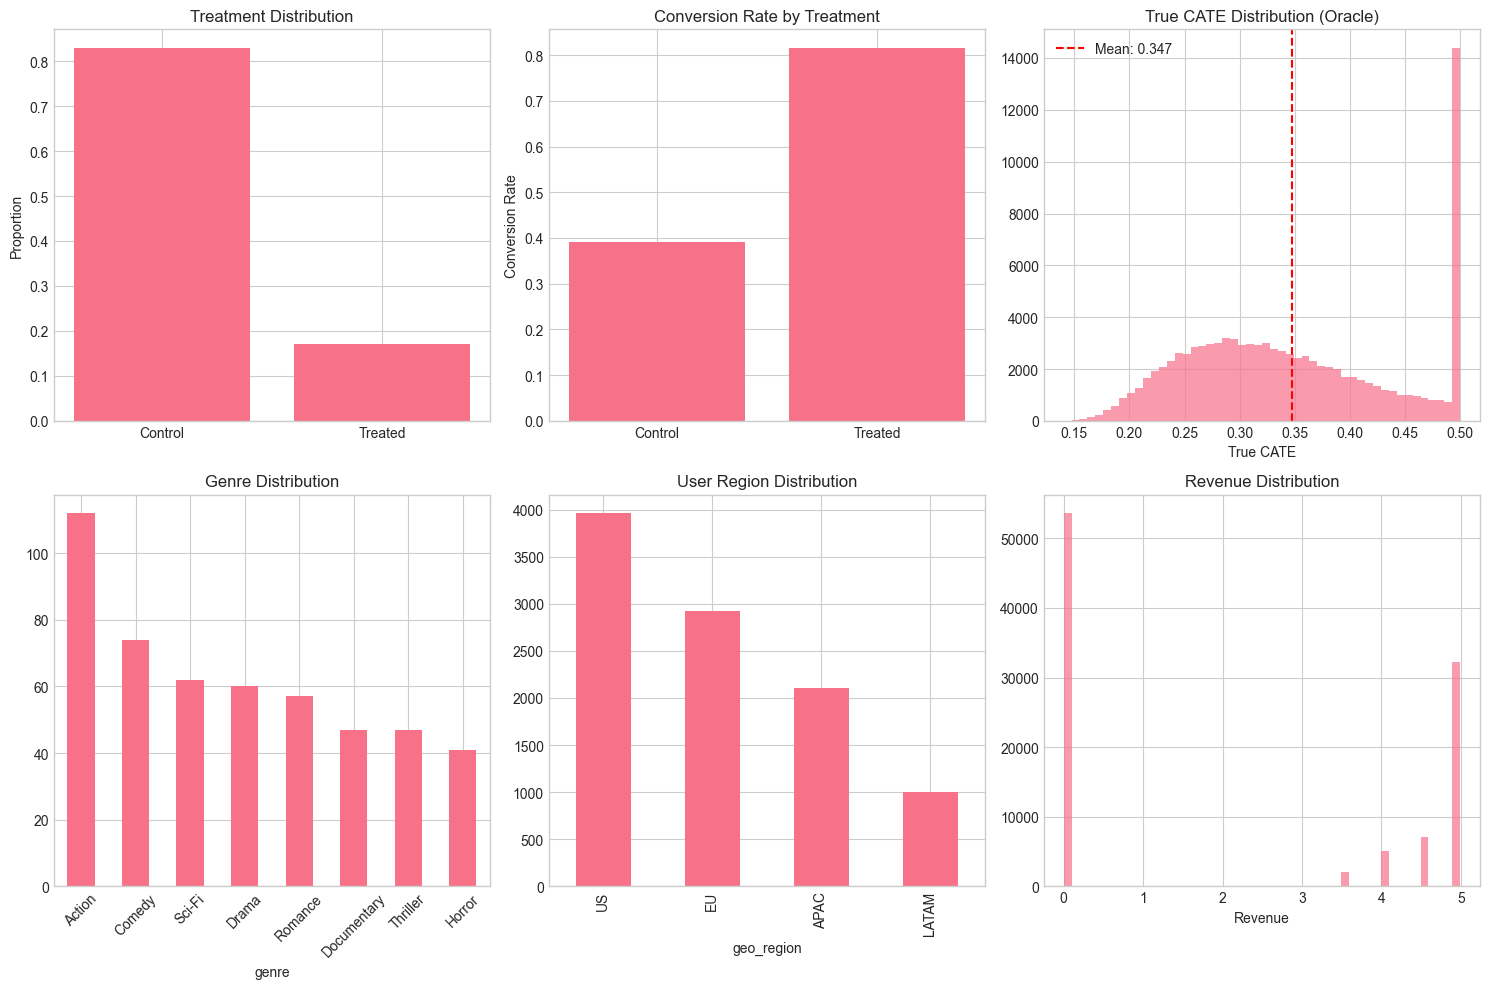

In [6]:
# Visualize data distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Treatment distribution
treatment_rate = data['treatment_log']['is_treated'].value_counts(normalize=True)
axes[0, 0].bar(['Control', 'Treated'], [treatment_rate[False], treatment_rate[True]])
axes[0, 0].set_title('Treatment Distribution')
axes[0, 0].set_ylabel('Proportion')

# Conversion by treatment
outcomes = data['interaction_outcomes'].merge(
    data['treatment_log'][['user_id', 'title_id', 'is_treated']], 
    on=['user_id', 'title_id']
)
conv_by_treatment = outcomes.groupby('is_treated')['did_rent'].mean()
axes[0, 1].bar(['Control', 'Treated'], [conv_by_treatment[False], conv_by_treatment[True]])
axes[0, 1].set_title('Conversion Rate by Treatment')
axes[0, 1].set_ylabel('Conversion Rate')

# True CATE distribution
axes[0, 2].hist(data['interaction_outcomes']['true_cate'], bins=50, alpha=0.7)
axes[0, 2].axvline(data['interaction_outcomes']['true_cate'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {data['interaction_outcomes']['true_cate'].mean():.3f}")
axes[0, 2].set_title('True CATE Distribution (Oracle)')
axes[0, 2].set_xlabel('True CATE')
axes[0, 2].legend()

# Genre distribution
data['titles_metadata']['genre'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Genre Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)

# Region distribution
data['users_metadata']['geo_region'].value_counts().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('User Region Distribution')

# Revenue distribution
axes[1, 2].hist(data['interaction_outcomes']['revenue_generated'], bins=50, alpha=0.7)
axes[1, 2].set_title('Revenue Distribution')
axes[1, 2].set_xlabel('Revenue')

plt.tight_layout()
plt.show()

---

## 2. Feature Engineering

Transform raw data into a feature matrix suitable for modeling.

In [7]:
# Create modeling dataset
modeling_df = generator.create_modeling_dataset(data)
print(f"Modeling dataset shape: {modeling_df.shape}")
display(modeling_df.head())

Modeling dataset shape: (102586, 23)


,user_id,title_id,discount_level,campaign_id,timestamp,is_treated,did_rent,revenue_generated,watch_duration_minutes,base_price,true_cate,y0,y1,subscription_tenure_months,geo_region,device_type,avg_daily_watch_time,price_sensitivity,genre,director,release_year,is_cold_start,base_popularity
0,USER_004543,TITLE_00076,0.0000,NO_TREATMENT,2024-02-29 08:08:55.639001,False,True,4.9900,73.2667,4.9900,0.4035,0.4520,0.8555,61,APAC,Desktop,62.0490,0.4739,Sci-Fi,Director_G,2019,False,0.8219
1,USER_004819,TITLE_00380,0.0000,NO_TREATMENT,2024-02-15 22:54:02.568372,False,True,4.9900,94.0568,4.9900,0.4908,0.3371,0.8279,76,LATAM,SmartTV,90.5196,0.5078,Sci-Fi,Director_L,2011,False,0.1698
2,USER_006415,TITLE_00186,0.0000,NO_TREATMENT,2024-01-08 18:02:17.541445,False,False,0.0000,0.0000,4.9900,0.4468,0.4043,0.8511,12,EU,SmartTV,94.6965,0.5864,Sci-Fi,Director_N,2020,False,0.5259
3,USER_007612,TITLE_00046,0.2000,CAMP_002,2024-01-27 22:48:45.199324,True,True,3.9920,54.2991,4.9900,0.5000,0.4083,0.9083,56,LATAM,Mobile,44.1060,0.4953,Action,Director_B,2018,False,0.7552
4,USER_005058,TITLE_00431,0.0000,NO_TREATMENT,2024-03-30 02:01:36.510526,False,False,0.0000,0.0000,4.9900,0.2704,0.3521,0.6224,2,US,Tablet,62.2787,0.3667,Horror,Director_C,2019,False,0.3563


In [8]:
# Initialize and fit feature transformer
transformer = FeatureTransformer(
    handle_cold_start=True,
    include_embeddings=False  # Skip embeddings for this demo
)

# Fit and transform
X = transformer.fit_transform(data, modeling_df)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(transformer.get_feature_names())}")
print(f"\nFeature names: {transformer.get_feature_names()[:20]}...")

Feature matrix shape: (102586, 42)
Number of features: 42

Feature names: ['genre_Action', 'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror', 'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'geo_region_APAC', 'geo_region_EU', 'geo_region_LATAM', 'geo_region_US', 'device_type_Desktop', 'device_type_Mobile', 'device_type_SmartTV', 'device_type_Tablet', 'director_Director_A', 'director_Director_B', 'director_Director_C', 'director_Director_D']...


In [9]:
# Prepare target and treatment variables
y = modeling_df['did_rent'].astype(int)
treatment = modeling_df['is_treated'].astype(int)
true_cate = modeling_df['true_cate']

print(f"Outcome distribution: {y.value_counts().to_dict()}")
print(f"Treatment distribution: {treatment.value_counts().to_dict()}")

Outcome distribution: {0: 54978, 1: 47608}
Treatment distribution: {0: 85070, 1: 17516}


### 2.1 Propensity Scoring

Train a propensity model and check overlap assumption.

In [10]:
# Train propensity model
propensity_model = PropensityModel(model_type='xgboost')
propensity_model.fit(X, treatment)

# Get propensity scores
propensity = propensity_model.predict_propensity(X)

# Check overlap
overlap_diagnostics = propensity_model.check_overlap(X, treatment)
print("Propensity Score Diagnostics:")
print("="*50)
for key, value in overlap_diagnostics.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.4f}")
    else:
        print(f"{key:30s}: {value}")

Propensity Score Diagnostics:
propensity_mean               : 0.17050248384475708
propensity_std                : 0.029907643795013428
propensity_min                : 0.05799352377653122
propensity_max                : 0.48465004563331604
near_zero_count               : 262
near_zero_pct                 : 0.2554
near_one_count                : 0
near_one_pct                  : 0.0000
overlap_ok                    : True
propensity_treated_mean       : 0.18074741959571838
propensity_control_mean       : 0.1683930605649948


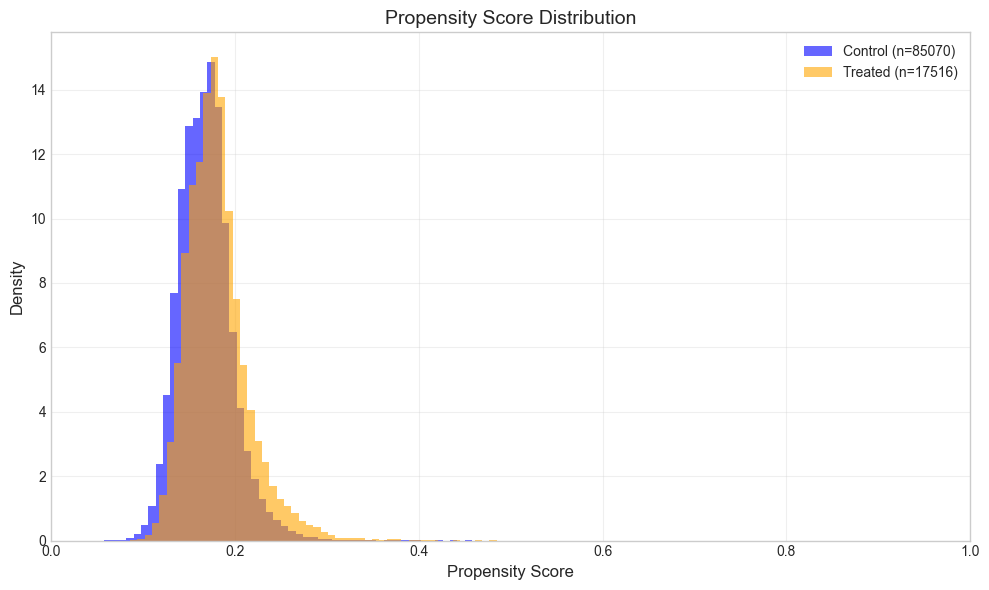

In [11]:
# Visualize propensity distribution
fig = plot_propensity_distribution(propensity, treatment)
plt.show()

---

## 3. X-Learner Training

Train the X-Learner with XGBoost base learners.

In [12]:
# Initialize X-Learner
xlearner = XLearner(
    base_learner_params={'n_estimators': 100, 'max_depth': 6},
    propensity_model_type='xgboost',
    random_state=42
)

# Fit the model
print("Training X-Learner...")
xlearner.fit(X, y, treatment)
print("Training complete!")

# Get diagnostics
diagnostics = xlearner.get_diagnostics()
print("\nModel Diagnostics:")
for key, value in diagnostics.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for k, v in value.items():
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
    else:
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

Training X-Learner...
Training complete!

Model Diagnostics:
n_control: 85070
n_treatment: 17516
d0_mean: 0.4202
d0_std: 0.5030
d1_mean: 0.4297
d1_std: 0.3963
base_learners:
  n_control: 85070
  n_treatment: 17516
  control_fraction: 0.8293
  treatment_fraction: 0.1707


In [13]:
# Predict CATE
predicted_cate = xlearner.predict(X)

print(f"Predicted CATE statistics:")
print(f"  Mean: {predicted_cate.mean():.4f}")
print(f"  Std:  {predicted_cate.std():.4f}")
print(f"  Min:  {predicted_cate.min():.4f}")
print(f"  Max:  {predicted_cate.max():.4f}")

Predicted CATE statistics:
  Mean: 0.4221
  Std:  0.1332
  Min:  -0.8327
  Max:  0.7685


In [14]:
# Feature importance for CATE
feature_names = transformer.get_feature_names()
importance_df = xlearner.get_feature_importance(
    model='cate',
    feature_names=feature_names[:X.shape[1]],  # Match feature count
    top_k=15
)

print("\nTop 15 CATE-Driving Features:")
display(importance_df)


Top 15 CATE-Driving Features:


,feature,importance
0,base_popularity_scaled,0.0545
1,genre_Action,0.0539
2,geo_region_APAC,0.0423
3,avg_daily_watch_time_scaled,0.0380
4,geo_region_EU,0.0328
5,director_Director_F,0.0295
6,geo_region_US,0.0285
7,price_sensitivity_scaled,0.0281
8,geo_region_LATAM,0.0275
9,director_Director_H,0.0245


---

## 4. Model Evaluation

Evaluate the model using Qini curves, AUUC, and comparison to oracle ground truth.

In [17]:
# Compute Qini curve
qini_x, qini_y = UpliftMetrics.compute_qini_curve(
    y_true=y.values,
    treatment=treatment.values,
    predictions=predicted_cate
)

# Compute AUUC
auuc = UpliftMetrics.compute_auuc(qini_x, qini_y, normalize=True)
print(f"Area Under Uplift Curve (AUUC): {auuc:.4f}")

# Plot Qini curve
fig = plot_qini_curve(
    qini_x, qini_y,
    title=f"Qini Curve (AUUC: {auuc:.4f})"
)
plt.show()

AttributeError: module 'numpy' has no attribute 'trapz'

In [ ]:
# Compare to oracle ground truth
oracle_mse = UpliftMetrics.compute_oracle_mse(predicted_cate, true_cate.values)
oracle_corr = UpliftMetrics.compute_oracle_correlation(predicted_cate, true_cate.values)

print(f"Oracle Validation Metrics:")
print(f"  MSE (Predicted vs True CATE): {oracle_mse:.6f}")
print(f"  Correlation: {oracle_corr:.4f}")

In [ ]:
# Plot CATE distribution comparison
fig = plot_cate_distribution(
    predicted_cate=predicted_cate,
    true_cate=true_cate.values,
    title="Predicted vs True CATE Distribution"
)
plt.show()

In [ ]:
# Calibration plot
fig = plot_cate_calibration(
    predicted_cate=predicted_cate,
    true_cate=true_cate.values,
    n_bins=10,
    title="CATE Calibration Plot"
)
plt.show()

In [ ]:
# Uplift by percentile
uplift_df = UpliftMetrics.compute_uplift_by_percentile(
    y_true=y.values,
    treatment=treatment.values,
    predictions=predicted_cate,
    n_bins=10
)

print("Observed Uplift by Predicted Percentile:")
display(uplift_df)

---

## 5. Policy Simulation

Generate promotional recommendations and simulate campaign performance.

In [ ]:
# Initialize policy ranker
ranker = PolicyRanker(
    discount_cost=0.50,  # $0.50 cost per discount offered
    min_expected_roi=0.0,
    base_price=4.99
)

# Prepare user-title pairs for ranking
user_title_pairs = modeling_df[['user_id', 'title_id']].copy()
if 'genre' in modeling_df.columns:
    user_title_pairs['genre'] = modeling_df['genre']

# Generate recommendations
recommendations = ranker.rank(
    user_title_pairs=user_title_pairs,
    predicted_uplift=predicted_cate,
    top_k=5
)

print(f"Generated {len(recommendations)} recommendations")
print(f"For {recommendations['user_id'].nunique()} users")
display(recommendations.head(20))

In [ ]:
# Simulate policy performance
outcomes_for_sim = modeling_df[['user_id', 'title_id', 'did_rent']].copy()
outcomes_for_sim['is_treated'] = treatment.values

simulation_results = ranker.simulate_policy(
    recommendations=recommendations,
    outcomes_df=outcomes_for_sim,
    treatment_col='is_treated',
    outcome_col='did_rent'
)

print("\nPolicy Simulation Results:")
print("="*50)
for key, value in simulation_results.items():
    if isinstance(value, float):
        print(f"{key:35s}: {value:.4f}")
    else:
        print(f"{key:35s}: {value}")

In [ ]:
# Compare different targeting intensities
k_results = ranker.successive_k_item_ranking(
    user_title_pairs=user_title_pairs,
    predicted_uplift=predicted_cate,
    k_values=[1, 3, 5, 10, 20]
)

print("\nRecommendations at Different k Values:")
for k, recs in k_results.items():
    avg_uplift = recs['predicted_uplift'].mean() if len(recs) > 0 else 0
    avg_roi = recs['expected_roi'].mean() if len(recs) > 0 else 0
    print(f"  k={k:2d}: {len(recs):6d} recs, avg_uplift={avg_uplift:.4f}, avg_roi=${avg_roi:.2f}")

In [ ]:
# Create campaign report
report = ranker.create_campaign_report(
    recommendations=recommendations,
    title_metadata=data['titles_metadata'],
    user_metadata=data['users_metadata']
)

print("Overall Summary:")
display(report['overall'])

print("\nBy Genre:")
display(report['by_genre'])

print("\nBy Region:")
display(report['by_region'])

---

## Summary

In this notebook, we demonstrated:

1. **Synthetic Data Generation**: Created a realistic VOD dataset with hidden causal effects using `VODSyntheticData` and `CausalOracle`

2. **Feature Engineering**: Transformed raw logs into model features with one-hot encoding, cyclical timestamps, and cold-start handling

3. **X-Learner Training**: Trained a causal uplift model using the X-Learner meta-learner with XGBoost base models

4. **Evaluation**: Validated the model using Qini curves, AUUC, and comparison to oracle ground truth

5. **Policy Simulation**: Generated ROI-optimized promotional recommendations and simulated campaign performance

### Key Findings

- The X-Learner successfully learns the heterogeneous treatment effects
- Model predictions correlate well with true CATE (oracle)
- Targeting users by predicted uplift delivers significantly higher ROI than random targeting